In [3]:
import tensorflow as tf
from sklearn.model_selection import KFold
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers.legacy import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.regularizers import l2
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow.keras.layers as kl
import os

# Load the CSV files containing image labels
train_df = pd.read_csv('../Dataset/Labels/TrainLabels.csv')
test_df = pd.read_csv('../Dataset/Labels/TestLabels.csv')
validation_df = pd.read_csv('../Dataset/Labels/ValidationLabels.csv')

In [22]:
def graphs(history):
    #Accuracy graph
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label='val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('accuracy')
    plt.ylim([0, 1.0])
    plt.legend(loc='upper left')
    plt.show()

    #Loss graph
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.show()

def augment_image(image):
    # Mirror flip
    # black_white = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    flipped = tf.image.flip_left_right(image)
    # Transpose flip
    transposed = tf.image.transpose(image)
    # Saturation
    saturated = tf.image.adjust_saturation(flipped, 3)
    # Brightness
    brightness = tf.image.adjust_brightness(saturated, 0.4)
    # Contrast
    contrast = tf.image.random_contrast(brightness, lower=0.0, upper=1.0)

    # Resize at the end
    # images = [flipped, transposed, saturated, brightness, contrast]
    return contrast


def plot_images(images, labels, title):
    plt.figure(figsize=(10, 10))
    for i in range(min(len(images), 9)):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        plt.title(f'Label: {labels[i]}')
        plt.axis('off')
    plt.suptitle(title)
    plt.show()


def normalize_class_values(df):
    classes = ['Boredom', 'Engagement', 'Confusion', 'Frustration']
    max_possible_value = 3

    for index, row in df.iterrows():
        if row['Boredom'] == 1 or row['Confusion'] == 1 or row['Frustration'] == 1:
            df.at[index, 'Engagement'] = 2
        elif row['Boredom'] > 1 or row['Confusion'] > 1 or row['Frustration'] > 1:
            df.at[index, 'Engagement'] = 1

        if row['Frustration'] == 1:
            df.at[index, 'Frustration'] = 2
        elif row['Frustration'] == 2:
            df.at[index, 'Frustration'] = 3

        if row['Confusion'] == 1:
            df.at[index, 'Confusion'] = 2
        elif row['Confusion'] == 2:
            df.at[index, 'Confusion'] = 3
            
        # if row['Frustration'] > 30 or row['Confusion'] > 0 or row['Boredom'] > 0:
        #     df.at[index, 'Engagement'] = 1
            

    for class_name in classes:
        df[class_name] = round(df[class_name] / max_possible_value, 1)  # Round to 1 decimal place

    return df


# Update the 'ClipID' column in the CSV files to include the full path to each frame
def generate_full_paths(row, dataset_dir):
    video_name = row['ClipID'].strip()  # Remove any leading or trailing whitespaces
    full_paths = [os.path.join(dataset_dir, f'{video_name[:-4]}{i}.jpg') for i in range(0, 5)]
    return full_paths


def model():
    model = tf.keras.Sequential()

    model.add(kl.InputLayer(input_shape=(80, 244, 3)))
    model.add(kl.Conv2D(filters=64, kernel_size=3, padding='same', strides=1, activation='relu'))
    # model.add(kl.BatchNormalization())
    model.add(kl.MaxPooling2D(pool_size=(2, 2)))
    model.add(kl.Dropout(0.4))
    # First conv block
    model.add(kl.Conv2D(filters=128, kernel_size=3, padding='same', strides=1, activation='relu'))
    # model.add(kl.BatchNormalization())
    model.add(kl.MaxPooling2D(pool_size=(2, 2)))
    model.add(kl.Dropout(0.4))  
    
    # Second conv block
    model.add(kl.Conv2D(filters=128, kernel_size=3, padding='same', strides=2, activation='relu'))
    # model.add(kl.BatchNormalization())
    model.add(kl.MaxPooling2D(pool_size=(2, 2)))
    model.add(kl.Dropout(0.4))
    
    model.add(kl.Conv2D(filters=256, kernel_size=3, strides=2, padding='same',activation='relu'))
    model.add(kl.BatchNormalization())
    model.add(kl.MaxPooling2D(pool_size=(2, 2)))
    model.add(kl.Dropout(0.4))
    
    # Flatten
    model.add(kl.Flatten())
    
    # First FC
    model.add(kl.Dense(1024, activation='relu'))
    # model.add(kl.BatchNormalization())
    # model.add(kl.Dropout(0.5))
    
    # Second Fc
    model.add(kl.Dense(512, activation='relu'))
    # model.add(kl.BatchNormalization())
    # model.add(kl.Dropout(0.5))
    # model.add(kl.Dense(256))
    # Output FC with sigmoid at the end
    model.add(kl.Dense(4, activation='sigmoid', name='prediction'))
    
    return model


def saveModelWeights(model, test_acc):
    # Serialize and save model to JSON
    model_name = f'model_{test_acc:.4f}'
    model_json = model.to_json()
    with open(f'{model_name}.json', 'w') as json_file:
        json_file.write(model_json)
    # Save weights to JSON
    model.save_weights(f'{model_name}.h5')

In [23]:
# Load the CSV files containing image labels
train_df = pd.read_csv('../Dataset/Labels/TrainLabels.csv')
test_df = pd.read_csv('../Dataset/Labels/TestLabels.csv')
validation_df = pd.read_csv('../Dataset/Labels/ValidationLabels.csv')

# Specify K for KFold cross-validation
kfold = KFold(n_splits=5, shuffle=True)

# Define image data generators for training, testing, and validation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    preprocessing_function=augment_image
)
test_datagen = ImageDataGenerator(
    rescale=1./255,
)
validation_datagen = ImageDataGenerator(
    rescale=1./255,
)

# Construct paths for each dataset
train_df['ClipID'] = train_df.apply(lambda row: generate_full_paths(row, '../Dataset/Image_Dataset_3/Train/face_mesh_rois'), axis=1)
test_df['ClipID'] = test_df.apply(lambda row: generate_full_paths(row, '../Dataset/Image_Dataset_3/Test/face_mesh_rois'), axis=1)
validation_df['ClipID'] = validation_df.apply(
    lambda row: generate_full_paths(row, '../Dataset/Image_Dataset_3/Validation/face_mesh_rois'), axis=1)

# Flatten the DataFrame to have one row per frame
train_df = train_df.explode('ClipID').reset_index(drop=True)
test_df = test_df.explode('ClipID').reset_index(drop=True)
validation_df = validation_df.explode('ClipID').reset_index(drop=True)

train_df_normalized = normalize_class_values(train_df)
test_df_normalized = normalize_class_values(test_df)
validation_df_normalized = normalize_class_values(validation_df)

train_df, val_df = train_test_split(train_df_normalized, test_size=0.2, random_state=42)

# print(train_df_normalized['Engagement'].to_string(index=False))

classes = ['Boredom', 'Engagement', 'Confusion', 'Frustration']

earlyStopping = EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.00005,
    patience=11,
    verbose=1,
    restore_best_weights=True
)

lrScheduler = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=7,
    min_lr=1e-7,
    verbose=1
)

callbacks = [
    earlyStopping,
    lrScheduler,
]


Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_22 (Conv2D)          (None, 80, 244, 64)       1792      
                                                                 
 max_pooling2d_22 (MaxPooli  (None, 40, 122, 64)       0         
 ng2D)                                                           
                                                                 
 dropout_17 (Dropout)        (None, 40, 122, 64)       0         
                                                                 
 conv2d_23 (Conv2D)          (None, 40, 122, 128)      73856     
                                                                 
 max_pooling2d_23 (MaxPooli  (None, 20, 61, 128)       0         
 ng2D)                                                           
                                                                 
 dropout_18 (Dropout)        (None, 20, 61, 128)      

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/preprocessing/image.py:1137: UserWarning: Found 5026 invalid image filename(s) in x_col="ClipID". These filename(s) will be ignored.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/preprocessing/image.py:1137: UserWarning: Found 2035 invalid image filename(s) in x_col="ClipID". These filename(s) will be ignored.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/preprocessing/image.py:1137: UserWarning: Found 1179 invalid image filename(s) in x_col="ClipID". These filename(s) will be ignored.
  warnings.warn(


Epoch 1/100
257/257 [==============================] - 244s 941ms/step - loss: 0.5894 - accuracy: 0.6861 - val_loss: 0.6376 - val_accuracy: 0.7109 - lr: 1.0000e-04
Epoch 2/100
257/257 [==============================] - 242s 943ms/step - loss: 0.5639 - accuracy: 0.7029 - val_loss: 0.5876 - val_accuracy: 0.7109 - lr: 1.0000e-04
Epoch 3/100
257/257 [==============================] - 242s 944ms/step - loss: 0.5631 - accuracy: 0.7037 - val_loss: 0.5735 - val_accuracy: 0.7109 - lr: 1.0000e-04
Epoch 4/100
257/257 [==============================] - 238s 928ms/step - loss: 0.5653 - accuracy: 0.7011 - val_loss: 0.5609 - val_accuracy: 0.7109 - lr: 1.0000e-04
Epoch 5/100
257/257 [==============================] - 236s 919ms/step - loss: 0.5789 - accuracy: 0.6877 - val_loss: 0.5574 - val_accuracy: 0.7109 - lr: 1.0000e-04
Epoch 6/100
257/257 [==============================] - 237s 925ms/step - loss: 0.6086 - accuracy: 0.6755 - val_loss: 0.5878 - val_accuracy: 0.7054 - lr: 1.0000e-04
Epoch 7/100
257/

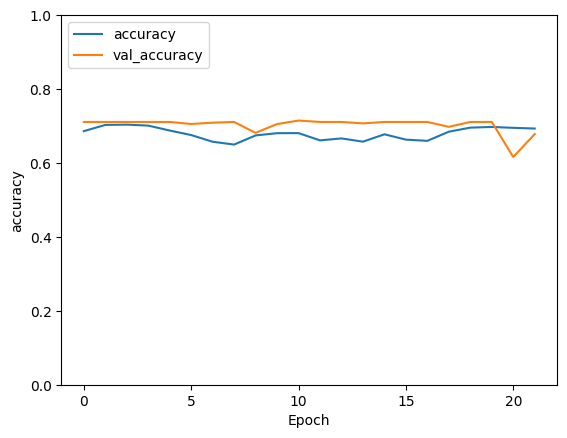

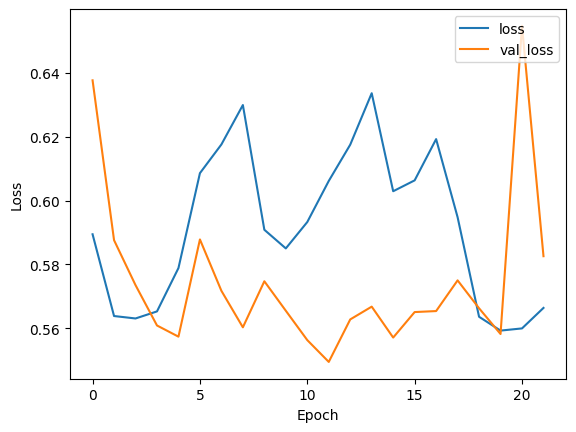

In [24]:
model = model()
model.summary()
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001, clipnorm=1.0), loss='binary_crossentropy', metrics=['accuracy'])

# for fold, (train_idx, val_idx) in enumerate(kfold.split(train_df_normalized)):
#     print(f"Training fold {fold + 1}")
# 
#     train_fold = train_df_normalized.iloc[train_idx]
#     val_fold = train_df_normalized.iloc[val_idx]
 
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='ClipID',
    y_col=['Boredom', 'Engagement', 'Confusion', 'Frustration'],
    target_size=(80, 244),
    batch_size=64,
    class_mode='raw',
    shuffle=True
)

# images, labels = next(train_generator)
# plot_images(images, labels, 'Train Images')

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df_normalized,
    x_col='ClipID',
    y_col=['Boredom', 'Engagement', 'Confusion', 'Frustration'],
    target_size=(80, 244),
    batch_size=64,
    class_mode='raw',
    shuffle=True,
)

# images, labels = next(test_generator)
# plot_images(images, labels, 'Test Images')

validation_generator = train_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='ClipID',
    y_col=['Boredom', 'Engagement', 'Confusion', 'Frustration'],
    target_size=(80, 244),
    batch_size=64,
    class_mode='raw',
    shuffle=True,
)

# images, labels = next(validation_generator)
# plot_images(images, labels, 'Validation Images')

# Train the model
history = model.fit(
    train_generator,
    epochs=100,
    validation_data=validation_generator,
    callbacks=callbacks
)

# Evaluate the model on the test set
test_images, test_labels = next(test_generator)
test_predictions = model.predict(test_images)
test_loss, test_acc = model.evaluate(test_images, test_labels)

print(f'Test accuracy: {test_acc}')

graphs(history)

saveModelWeights(model, test_acc)

In [ ]:
test_loss, test_acc = model.evaluate(test_images, test_labels)
 
# graphs(history)

# saveModelWeights(model, test_acc)

2/2 [==============================] - 0s 49ms/step
              precision    recall  f1-score   support

     Boredom       0.00      0.00      0.00         8
  Engagement       0.80      0.90      0.85        52
   Confusion       0.00      0.00      0.00         3
 Frustration       0.00      0.00      0.00         1

    accuracy                           0.73        64
   macro avg       0.20      0.23      0.21        64
weighted avg       0.65      0.73      0.69        64


/var/folders/wx/c2fc49pd4s7fq23msz0ypksh0000gn/T/ipykernel_15138/1827476047.py:18: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


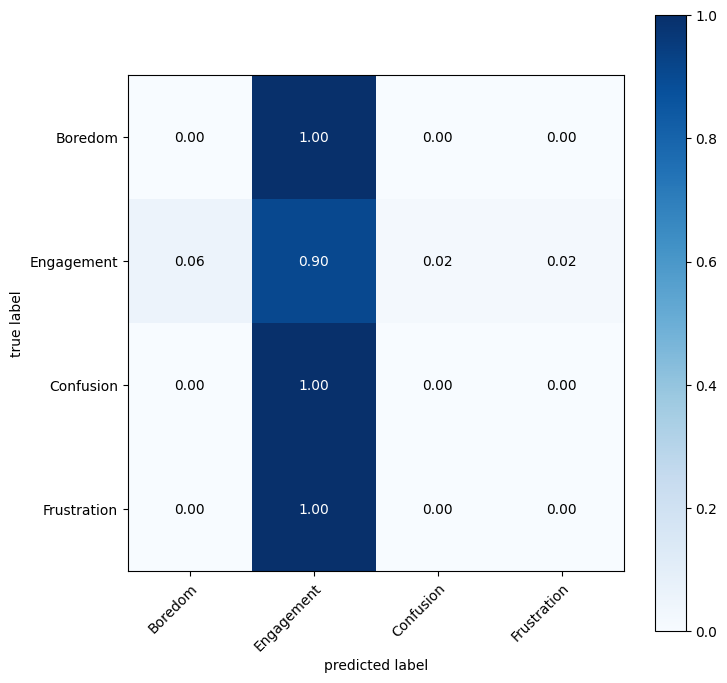

In [11]:
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import classification_report
import numpy as np

pred_test_labels = model.predict(test_images)

conf_mat = confusion_matrix(np.argmax(test_labels, axis=1), np.argmax(pred_test_labels, axis=1))

emotions = {0: 'Boredom', 1: 'Engagement', 2: 'Confusion', 3: 'Frustration'}

#Plot confusion matrix
fig, ax = plot_confusion_matrix(conf_mat=conf_mat,
                                colorbar=True,
                                show_normed=True,
                                show_absolute=False,
                                class_names=emotions.values(),
                                figsize=(8, 8))
fig.show()
#Print classifation report
print(classification_report(test_labels.argmax(axis=1), pred_test_labels.argmax(axis=1), target_names=emotions.values()))